# Demo of image classification using traditional ML method
1. Introduction to kNN classifier
2. Introduction to HOG feature descriptors
3. Demo of raw pixel + kNN and HOG + kNN

# Setup

In [1]:
import sys
assert sys.version_info >= (3, 8)

import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

# Understanding kNN classifier
The K-Nearest Neighbors (KNN) classifier is a widely used algorithm in supervised machine learning, primarily for classification tasks. 

## Overview
KNN operates on the principle that similar data points are likely to belong to the same class. When a new data point needs to be classified, the algorithm identifies the $k$ closest training examples in the feature space and assigns the most common class among them to the new point. This process is often referred to as majority voting, where the class with the highest frequency among the nearest neighbors is chosen as the predicted class label.

## Characteristics of kNN
1. **Lazy learner**: The algorithm does not build a model during training. Instead, it stores the entire training dataset and performs computations only when a classification is requested. This characteristic can lead to high memory usage and computational costs, especially with large datasets.
2. **Distance metric**: KNN typically uses Euclidean distance to measure the proximity between data points, although other distance metrics such as Manhattan or Minkowski can also be employed depending on the specific application

## Approach 1: With `cv.ml.KNearest_create()`

results: [[0.]]
neighbors: [[1. 0. 0.]]
distances: [[ 36. 233. 234.]]


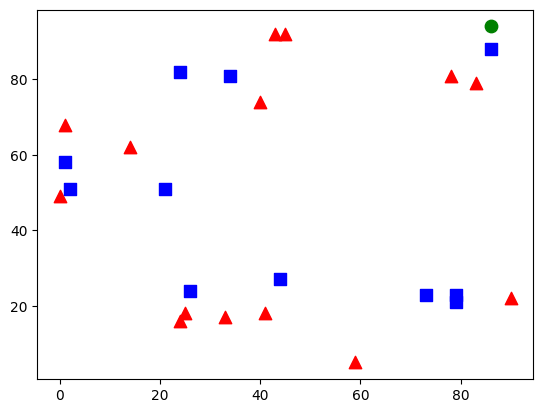

In [2]:
# set up the rng
rng = np.random.default_rng(123)

# artificial generation of training data and labels
train_data = rng.integers(0, high=100, size=(25, 2)).astype(np.float32)
response = rng.integers(0, high=2, size=(25, 1)).astype(np.float32)

# take the data with labels zero
red = train_data[response.flatten() == 0]
plt.scatter(red[:, 0], red[:, 1], 80, 'r', '^')

# take the data with labels 1
blue = train_data[response.flatten() == 1]
plt.scatter(blue[:, 0], blue[:, 1], 80, 'b', 's')

# new query data
newcomer = rng.integers(0, high=100, size=(1, 2)).astype(np.float32)
plt.scatter(newcomer[:, 0], newcomer[:, 1], 80, 'g', 'o')

knn = cv.ml.KNearest_create()
knn.train(train_data, cv.ml.ROW_SAMPLE, response)
ret, results, neighbors, dist = knn.findNearest(newcomer, 3)

print(f"results: {results}")
print(f"neighbors: {neighbors}")
print(f"distances: {dist}")

plt.show()

## Approach 2: with sklearn

In [3]:
!pip install -U scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.9 MB 919.0 kB/s eta 0:00:12
    --------------------------------------- 0.2/10.9 MB 2.0 MB/s eta 0:00:06
    --------------------------------------- 0.2/10.9 MB 2.0 MB/s eta 0:00:06
    --------------------------------------- 0.2/10.9 MB 2.0 MB/s eta 0:00:06
   - -------------------------------------- 0.3/10.9 MB 1.1 MB/s eta 0:00:11
   - -------------------------------------- 0.4/10.9 MB 1.3 MB/s eta 0:00:09
   -- ------------------------------------- 0.6/10.9 MB 1.6 MB/s eta 0:00:07
   -- ------------------------------------- 0.6/10.9 MB 1.7 MB/s eta 0:00:07
   -- ------------------------------------- 0.6/10.9 MB 1.7 MB/s eta 0:00:07
   -- ---------------------------


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn.fit(train_data, response.ravel())
print("The prediction of new data: ", knn.predict(newcomer))

The prediction of new data:  [0.]


Retrieve the nearest neighbors information

In [6]:
dist, labels_neigh = knn.kneighbors(newcomer)

print("The nearest neighbors:")
print("======")
print(response[labels_neigh.flatten()])
print(dist)

The nearest neighbors:
[[1.]
 [0.]
 [0.]]
[[ 6.         15.26433752 15.29705854]]


# Intro to HOG feature descriptor
The Histogram of Oriented Gradients (HOG) is a powerful feature descriptor used extensively in computer vision and image processing. It captures the distribution of gradient orientations in localized portions of an image, making it effective for recognizing shapes and patterns.

For more in-depth HOG concept understanding, you may refer to this [LearnOpenCV article](https://learnopencv.com/histogram-of-oriented-gradients/).

This section is primarily inspired by this [Medium Post](https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d).

There is built-in HOG descriptor extraction in OpenCV and the API together with its default input arguments are as shown below:
```
cv.HOGDescriptor(blockSize=(16, 16), blockStride=(8, 8), cellSize=(8, 8), nbins=9, nlevels=64, winSize=(64, 128), gammaCorrection, histogramNormType, L2HysThreshold, signedGradient, winSigma)
```

**Input arguments**:
1. `winSize`: Size of detection window, default: $(64, 128)$
2. `blockSize`: Size of blocks to calculate HOG, which affects the granularity of feature extraction.
3. `blockStride`: Step size for moving the block window, which controls the overlap between adjacent blocks.
4. `cellSize`: Size of cells within each block.
5. `nbins`: Number of bins for HOG, default 9 (int).
6. `derivAperture`: controls the size of the Sobel filter for gradient computation, default 1 (int, optional)
7. `winSigma`: parameter for Gaussian smoothing of the window. If set to -1, default value is used (double, optional).
8. `histogramNormType`: normalization method for the histogram. Default `HOGDescriptor::L2Hys` (optional).
9. `L2HysThreshold`: default: 0.2, double, optional
10. `gammaCorrection`: whether to apply gamma correction (default: `True`, boolean, optional)
11. `nlevels`: maximum number of detection window increases. default: 64. (int, optional)
12. `signedGradient`: whether to use signed gradients (default: `False`).

In [7]:
from utils import display_image, display_images

In [9]:
img = cv.imread('images/dog.jfif')
# crop and resize
crop = img[15:155, 100:190]
resized = cv.resize(crop, (64, 128))

display_image("dog", resized)

In [11]:
gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
win_size = gray.shape[::-1]
cell_size = (8, 8)
block_size = (16, 16)
block_stride = (8, 8)
num_bins = 9

hog = cv.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

hog_descriptor = hog.compute(gray)

print('HOG descriptor: ', hog_descriptor)
print('shape of HOG: ', hog_descriptor.shape)

HOG descriptor:  [0.01074185 0.06471306 0.17717467 ... 0.18805464 0.17151092 0.23054941]
shape of HOG:  (3780,)


# Demo of raw pixel + kNN in image classification 

## Workflow overview
![workflow of image classification](img_embed/w9_workflow1.png)

## Data acquisition
We will make use of fashion-mnist dataset hosted on public [GitHub](https://github.com/zalandoresearch/fashion-mnist) repo.

1. Download the GitHub repo and unzip the file. Transfer all the files and directory into your working directory.
2. Insert the filepath as the system path.

In [12]:
sys.path

['C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\Scripts',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312',
 'D:\\UTAR course\\UCCC2513 mini project\\codes_2024\\myenv',
 '',
 'D:\\UTAR course\\UCCC2513 mini project\\codes_2024\\myenv\\Lib\\site-packages',
 'D:\\UTAR course\\UCCC2513 mini project\\codes_2024\\myenv\\Lib\\site-packages\\win32',
 'D:\\UTAR course\\UCCC2513 mini project\\codes_2024\\myenv\\Lib\\site-packages\\win32\\lib',
 'D:\\UTAR course\\UCCC2513 mini project\\codes_2024\\myenv\\Lib\\site-packages\\Pythonwin']

In [13]:
sys.path.insert(0, 'D:/UTAR course/UCCC2513 mini project/codes_2024/myenv/fashion-mnist-master/utils')

In [14]:
import mnist_reader

X_train, y_train = mnist_reader.load_mnist('./myenv/fashion-mnist-master/data/fashion', kind="train")
X_test, y_test = mnist_reader.load_mnist('./myenv/fashion-mnist-master/data/fashion', kind="t10k")

In [15]:
print("The shape of training data: ", X_train.shape)
print("The shape of training label: ", y_train.shape)
print("The shape of test data: ", X_test.shape)
print("The shape of test label: ", y_test.shape)

The shape of training data:  (60000, 784)
The shape of training label:  (60000,)
The shape of test data:  (10000, 784)
The shape of test label:  (10000,)


## data visualization

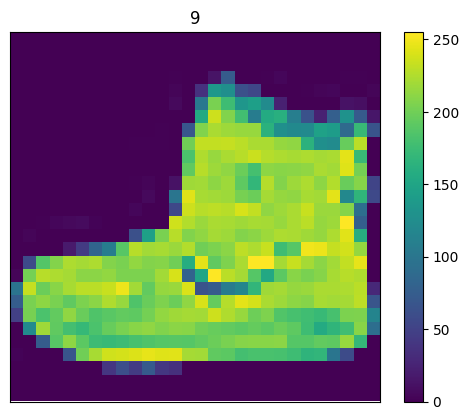

In [16]:
plt.figure()
plt.imshow(X_train[0].reshape(28, 28))
plt.colorbar()
plt.title(y_train[0])
plt.xticks([]), plt.yticks([])
plt.show()

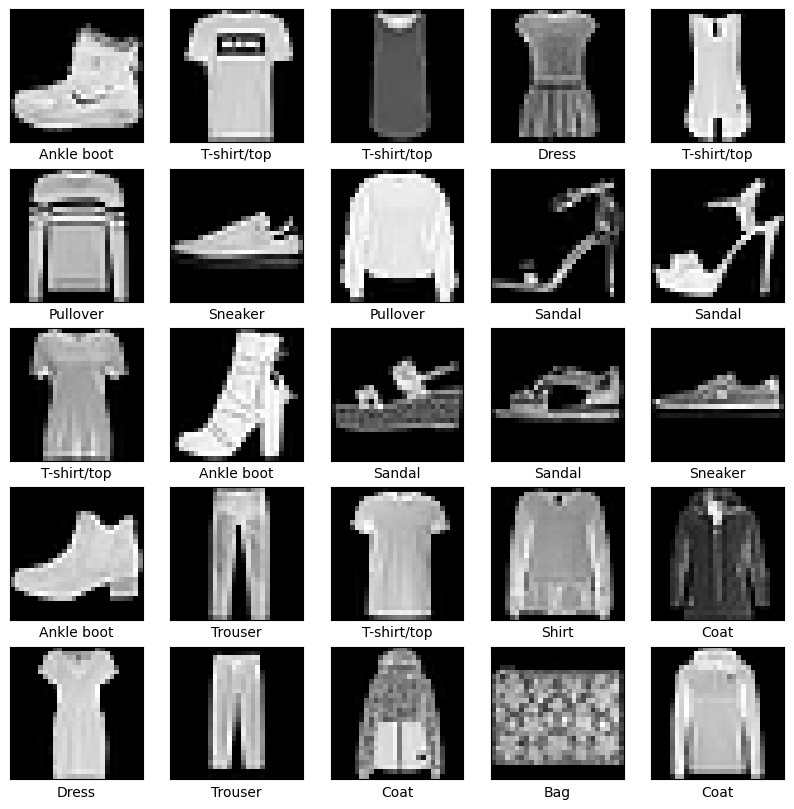

In [18]:
# create a class name list
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
               "Bag", "Ankle boot"]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.gray, vmin=0, vmax=255)
    plt.xticks([]), plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[y_train[i]])

plt.show()

## Data preprocessing
Further divide the training dataset to obtain validation dataset (i.e. a smaller dataset for hyperparameter tuning).

Here you can either choose to *sample the data randomly* or perform *stratified sampling*. In this demo, we will use random sampling. If you are interested with stratied sampling, you can use `train_test_split` function provided by `sklearn.model_selection`.

In [19]:
# random sampling (allocate 10% of training set for validation set)
rng = np.random.default_rng(321)
random_seq = rng.permutation(len(X_train))
sample_size = int(0.1 * len(X_train))
idx = random_seq[:sample_size]

X_val, y_val = X_train[idx], y_train[idx]

## Hyperparameter tuning
We now want to know what number of nearest neighbors is the best configuration for kNN classifier.

> Note 🗈
> 
> Theoretically speaking, we can use the entire training dataset to find the best k. But if you are using k-fold cross validation, the hyperparameter tuning process will become painstakingly slow if your training data and search space is very large. 

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
k_list = np.arange(1, 21)  # 0-20

mean_acc = []
std_acc = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    scores = cross_val_score(knn, X_val, y_val, cv=5)
    mean_acc.append(scores.mean())
    std_acc.append(scores.std())

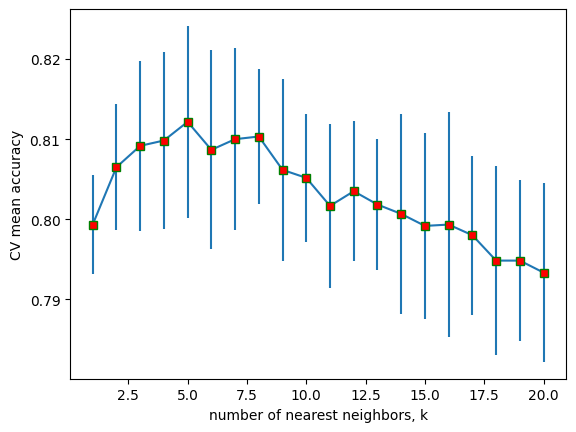

In [22]:
plt.figure()
plt.errorbar(k_list, mean_acc, std_acc, marker='s', mfc="red", mec="green")
plt.xlabel("number of nearest neighbors, k")
plt.ylabel("CV mean accuracy")
plt.show()

From the plot above, it seems like **k=5** is the best k.

## Model evaluation

In [23]:
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [25]:
# get the best k
k_best = np.argmax(mean_acc) + 1
# knn object
knn = KNeighborsClassifier(n_neighbors=k_best, n_jobs=-1)

start_time = time.time()
knn.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
pred = knn.predict(X_test)
pred_time = time.time() - start_time

print(classification_report(y_test, pred, target_names=class_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.77      0.85      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.82      0.77      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.79      0.77      0.78      1000
      Sandal       0.99      0.82      0.90      1000
       Shirt       0.66      0.57      0.61      1000
     Sneaker       0.88      0.96      0.92      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.90      0.97      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



In [26]:
print("training time: {}s".format(round(training_time, 4)))
print("prediction time: {}s".format(round(pred_time, 4)))

training time: 0.0157s
prediction time: 39.7649s


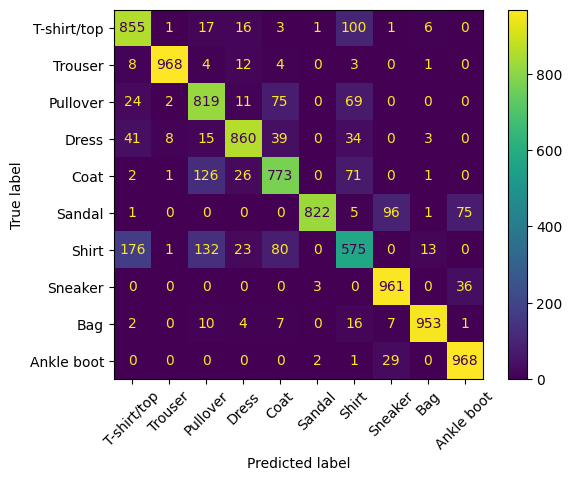

In [27]:
confusion_matrix = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, 
                                   display_labels=class_labels)

cm_display.plot()
plt.xticks(rotation=45)
plt.show()

# Demo of HOG + kNN on the same dataset

## Workflow overview
![workflow of HOG+kNN](img_embed/w9_workflow2.png)

## Define the HOG parameters

In [28]:
winSize = (28, 28)
blockSize = (14, 14)
blockStride = (7, 7)
cellSize = (7, 7)
nbins = 9  # same as default
# same as default
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
nlevels = 64
# different settings
gammaCorrection = False
signedGradient = True

hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, 
                      derivAperture, winSigma, histogramNormType, L2HysThreshold,
                      gammaCorrection, nlevels, signedGradient)

In [29]:
X_train_hog = [hog.compute(x.reshape(28, 28)) for x in X_train]
X_train_hog = np.array(X_train_hog)
print("shape of HOG transform data: ", X_train_hog.shape)

shape of HOG transform data:  (60000, 324)


### Standardize HOG descriptor

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_hog = scaler.fit_transform(X_train_hog)

In [30]:
idx.shape

(6000,)

In [32]:
X_val_hog = X_train_hog[idx]
print("shape of validation HOG transformed data: ", X_val_hog.shape)

shape of validation HOG transformed data:  (6000, 324)


In [33]:
k_list = np.arange(1, 21)

mean_acc = []
std_acc = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    scores = cross_val_score(knn, X_val_hog, y_val, cv=5)
    mean_acc.append(scores.mean())
    std_acc.append(scores.std())

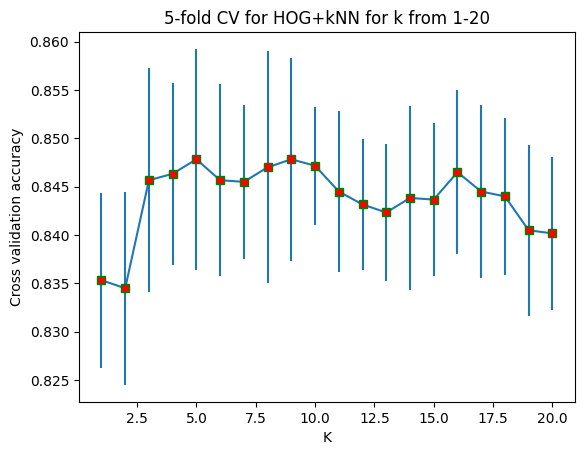

In [34]:
plt.figure()
plt.errorbar(k_list, mean_acc, std_acc, marker="s", mfc="r", mec="g")
plt.xlabel("K")
plt.ylabel("Cross validation accuracy")
plt.title("5-fold CV for HOG+kNN for k from 1-20")
plt.show()

In [36]:
np.argmax(mean_acc) + 1  # k=5 is the best k

5

In [37]:
# transform the X_test
X_test_hog = [hog.compute(x.reshape((28, 28))) for x in X_test]
X_test_hog = scaler.transform(X_test_hog)

# best k
k_best = np.argmax(mean_acc) + 1
# knn object
knn = KNeighborsClassifier(n_neighbors=k_best, n_jobs=-1)

start_time = time.time()
knn.fit(X_train_hog, y_train)
training_time = time.time() - start_time

start_time = time.time()
pred = knn.predict(X_test_hog)
pred_time = time.time() - start_time

print(classification_report(y_test, pred, target_names=class_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.83      0.78      0.80      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.76      0.82      0.79      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.68      0.69      0.69      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [38]:
print("training time: {}s".format(round(training_time, 4)))
print("prediction time: {}s".format(round(pred_time, 4)))

training time: 0.0156s
prediction time: 30.8029s


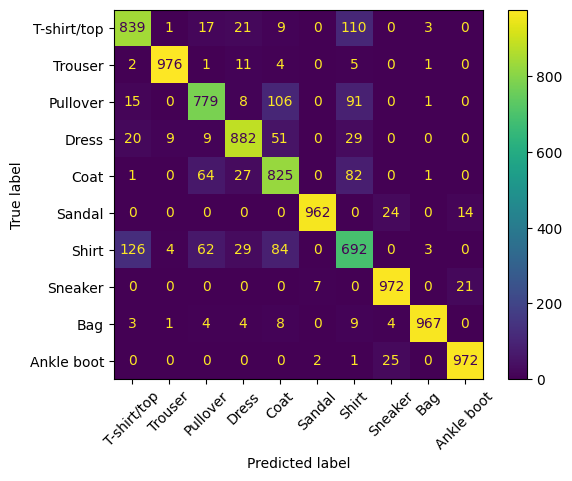

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                   display_labels=class_labels)

cm_display.plot()
plt.xticks(rotation=45)
plt.show()

# Summary
HOG + SVM performs better compared to raw pixels + SVM. This implies the importance of relevant feature extraction to enhance the performance of classifier.